# Mendenhall Proposal Supplementary Notebook

This notebook contains all the computations for the two-dimensional synthetic coseismic inversion. Prior constraints are imposed on the slip direction, potency of slip, and stress drop.  The posterior distribution of slip is found with a Metropolis-Hastings algorithm.

## Forward Problem

Our forward problem is for an vertical, infinitely long, strike-slip fault which is embedded in a homogeneous elastic half-space.  This geometry degenerates to a two-dimensional anti-plane displacement problem.  We discretize the fault into 10 segments  

In [10]:
%matplotlib inline
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar
import matplotlib.colors
import myplot.cm
np.random.seed(4)

In [11]:
def dislocation(obs,depth_top,depth_bottom):
  ''' 
  Returns the displacement at position x resulting from a 
  unit of left-lateral slip on a fault which extends from 
  'depth_top' to 'depth_bottom'  
  
  Parameters
  ----------
    obs: (N,2) array of observation points
    
    depth_top: scalar value for the depth to the top of the
      fault
    
    depth_bottom: scalar value for the depth to the bottom 
      of the fault
    
  '''
  # deep dislocation
  a = np.arctan2(obs[:,0],(obs[:,1] + depth_bottom))
  # deep image dislocation
  b = np.arctan2(obs[:,0],(obs[:,1] - depth_bottom))
  # shallow dislocation
  c = np.arctan2(obs[:,0],(obs[:,1] + depth_top))
  # shallow image
  d = np.arctan2(obs[:,0],(obs[:,1] - depth_top))
  return -(a - b - c + d)/(2*np.pi)


def dislocation_diff(obs,depth_top,depth_bottom):
  '''
  Returns the derivative in the displacement field with 
  respect to the x direction
  '''
  # deep dislocation
  r2 = obs[:,0]**2 + (obs[:,1] + depth_bottom)**2
  a = (obs[:,1] + depth_bottom)/r2  

  # deep image dislocation
  r2 = obs[:,0]**2 + (obs[:,1] - depth_bottom)**2
  b = (obs[:,1] - depth_bottom)/r2
 
  # deep dislocation
  r2 = obs[:,0]**2 + (obs[:,1] + depth_top)**2
  c = (obs[:,1] + depth_top)/r2  

  # deep image dislocation
  r2 = obs[:,0]**2 + (obs[:,1] - depth_top)**2
  d = (obs[:,1] - depth_top)/r2

  return -(a - b - c + d)/(2*np.pi)


def observation_matrix(obs,segments):
  '''
  Returns the observation matrix which maps a slip vector 
  to the observable displacements
  
  Parameters
  ----------
    obs: (N,2) array of observation points
   
    segments: (M,2) array of top and bottom depths for each 
      segment

  '''
  N = obs.shape[0]
  M = segments.shape[0]
  out = np.zeros((N,M))
  for i in range(M):
    out[:,i] = dislocation(obs,segments[i,0],segments[i,1])

  return out


def shear_stress_matrix(segments,mu=3.2e10):
  '''
  Returns a matrix which maps a vector of slip to the shear
  stress change at the center of each fault segment 
  
  Parameters
  ----------
    segments: (M,2) array of top and bottom depths for each 
      segment
  '''
  M = segments.shape[0]
  out = np.zeros((M,M))
  segment_centers_y = -np.mean(segments,axis=1)
  segment_centers_x = 0.0*segment_centers_y
  segment_centers = np.array([segment_centers_x,
                              segment_centers_y]).T  
  for i in range(M):
    out[:,i] = mu*dislocation_diff(segment_centers,
                                   segments[i,0],
                                   segments[i,1])
  
  return out  



## Synthetic data

We create synthetic displacements at 20 surface observation points.  Displacements are the result of slip with a uniform stress drop of 5 MPa from 0 to 15 km depth

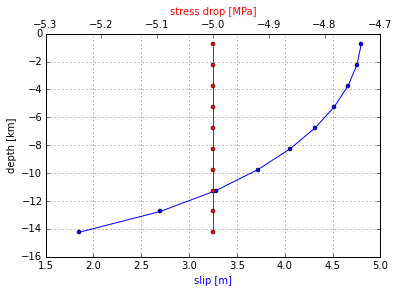

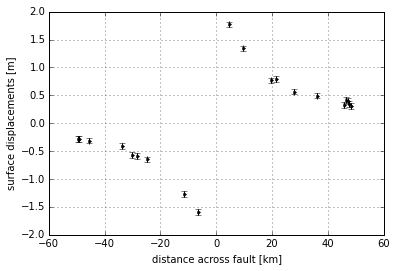

In [12]:
# number of observations
N = 20

# number of fault segments
M = 10

# chose the observation points with a uniform random 
# distribution from -50 to 50 km distance across the fault 
obs_x = np.random.uniform(-50000.0,50000.0,N)
obs_y = np.zeros(N)
obs = np.array([obs_x,obs_y]).T

# create fault segments
segments = np.linspace(0.0,15000.0,M+1)
segments = np.array([segments[:-1],segments[1:]]).T
segment_centers = -np.mean(segments,axis=1)

# create synthetic stress drop
true_stress_drop = -5e6*np.ones(M)

# convert stress drop to slip
K = shear_stress_matrix(segments)
Kinv = np.linalg.inv(K)
true_slip = Kinv.dot(true_stress_drop)

# create synthetic data
G = observation_matrix(obs,segments)
data = G.dot(true_slip)

# create synthetic noise
sigma = 0.05*np.ones(N)
noise = np.random.normal(0.0,sigma[0],N)
data += noise

# view true model and data
fig,ax1 = plt.subplots()
ax2 = ax1.twiny()
plt.figure(1)
ax1.plot(true_slip,segment_centers/1000.0,'bo-',
         markersize=4)
ax2.plot(true_stress_drop/1e6,segment_centers/1000.0,'ro-',
         markersize=4)
ax1.set_xlabel('slip [m]',color='b')
ax2.set_xlabel('stress drop [MPa]',color='r')
ax1.set_ylabel('depth [km]')
ax1.grid()

fig,ax = plt.subplots()
ax.errorbar(obs_x/1000.0,data,sigma,0*sigma,fmt='k.')
ax.set_xlabel('distance across fault [km]')
ax.set_ylabel('surface displacements [m]')
ax.grid()

## Define Metropolis-Hastings algorithm

In [13]:
def metropolis_hastings(initial_state,step_size,
                        Lprior_func,Lobs_func,
                        iterations=1000):
  # initialize output arrays for the postserior samples 
  # and the posterior likelihoods
  states = []
  Lposts = []
  Lprior = Lprior_func(initial_state)
  if Lprior <= 0.0:
    raise ValueError(
      'prior likelihood at initial state is less than or '
      'equal to zero')

  Lobs = Lobs_func(initial_state)
  if Lobs <= 0.0:
    raise ValueError(
      'observation likelihood at initial state is less '
      'than or equal to zero')

  states += [initial_state]
  Lposts += [Lprior*Lobs]
  for i in range(iterations):
    # proposed new state
    prop_state = np.random.normal(states[-1],step_size)
    prop_Lprior = Lprior_func(prop_state)
    if prop_Lprior <= 0.0:
      #there is no chance of accepting this
      continue

    prop_Lobs = Lobs_func(prop_state)
    if prop_Lobs <= 0.0:
      #there is no chance of accepting this
      continue

    prop_Lpost = prop_Lprior*prop_Lobs
    alpha = prop_Lpost/Lposts[-1]
    if alpha > np.random.uniform():
      states += [prop_state]
      Lposts += [prop_Lpost]

  states = np.array(states)
  Lposts = np.array(Lposts)
  return states,Lposts

## Define prior likelihood

Our prior constraints on slip are:

* Slip is in the direction of maximum shear stress (in this case, we assume that all slip is left-lateral)
* The prior potency of the slip is normally distributed with a mean value of 0.6 km^2 and standard deviation of 0.1 km^2. The potency of the true model is 0.58 km^2.  Here I am describing the potency as the slip integrated over the fault width.    
* Shear stress drop is not less than 10 MPa at any point on the fault. This is a more restrictive criterion than if I were to bound stress drop by the faults frictional strength   

In [14]:
def prior_likelihood(model):
  # enforce left-lateral slip
  if np.any(model < 0.0):
    return 0.0
  
  # compute stress drop    
  stress_drop = K.dot(model)
  if np.any(stress_drop < -10.0e6):
    return 0.0

  # if the slip directions and stress drops are agree with
  # the prior then compute the likelihood based on the 
  # potency of the test model
  potency = np.sum(model)*15000.0
  return np.exp(-0.5*((potency-600000.0)/100000.0)**2)

## Define observation likelihood

In [15]:
def observation_likelihood(model):
    L22 = np.linalg.norm(G.dot(model) - data)**2
    return np.exp(-0.5*L22)

## Perform inversion

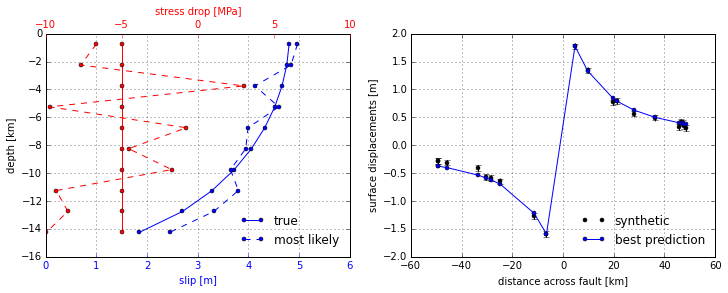

In [16]:
initial_state = 0.1 + np.zeros(M)
step_size = 0.05*np.ones(M)

# find the ensemble of posterior slip models and their 
# corresponding likelihoods
post_ensemble,post_likelihood = metropolis_hastings(
    initial_state,step_size,prior_likelihood,
    observation_likelihood,iterations=1000000)

# find the most likely slip model
best_slip = post_ensemble[np.argmax(post_likelihood)]

# compute the stress drop for the most likely model
best_stress_drop = K.dot(best_slip)

# compute the predicted surface displacements
predicted_data = G.dot(best_slip)


# plot the solution
fig,axs = plt.subplots(1,2,figsize=(12,4))
ax1 = axs[0]
ax2 = ax1.twiny()
plt.figure(1)
ax1.plot(true_slip,segment_centers/1000.0,'bo-',
         markersize=4)
ax1.plot(best_slip,segment_centers/1000.0,'bo--',
         markersize=4)
ax2.plot(true_stress_drop/1e6,segment_centers/1000.0,'ro-',
         markersize=4)
ax2.plot(best_stress_drop/1e6,segment_centers/1000.0,'ro--',
         markersize=4)
ax1.set_xlabel('slip [m]',color='b')
ax1.set_xlim((0.0,6.0))
ax2.set_xlabel('stress drop [MPa]',color='r')
ax2.set_xlim((-10,10))
ax1.set_ylabel('depth [km]')
ax1.legend(['true','most likely'],loc=4,frameon=False)
ax1.grid()
ax1.tick_params(axis='x', colors='blue')
ax2.tick_params(axis='x', colors='red')

ax = axs[1]
ax.errorbar(obs_x/1000.0,data,sigma,0*sigma,fmt='ko',
            markersize=4)
idx = np.argsort(obs_x)
ax.plot(obs_x[idx]/1000.0,predicted_data[idx],'bo-',
        markersize=4)
ax.set_xlabel('distance across fault [km]')
ax.set_ylabel('surface displacements [m]')
ax.legend(['synthetic','best prediction'],loc=4,
          frameon=False)
ax.grid()

plt.show()

## Plot the posterior distribution

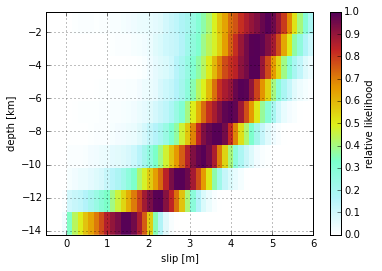

In [17]:
#Plot the marginal PDFs for each fault segment
Nbins = 50
bin_edges = np.linspace(-0.5,6,Nbins+1)
bins = np.array(zip(bin_edges[:-1],bin_edges[1:]))

bin_counts = np.zeros((M,Nbins))
for idx,b in enumerate(bins):
  bin_counts[:,idx] = np.sum((post_ensemble > b[0]) & (post_ensemble < b[1]),axis=0)   

max_counts = np.max(bin_counts,axis=1)
bin_counts /= max_counts[:,None]

im = plt.imshow(bin_counts,cmap=myplot.cm.slip2,
                extent=[-0.5,6,segment_centers[-1]/1000.0,segment_centers[0]/1000.0],
                aspect='auto',interpolation='none')
cbar = plt.colorbar(im)
plt.xlabel('slip [m]')
plt.ylabel('depth [km]')
cbar.set_label('relative likelihood')
plt.grid()

# Inversion with unbounded stress drop

for comparison, I run another inversion but I redefine the prior so that stress drop is not bounded

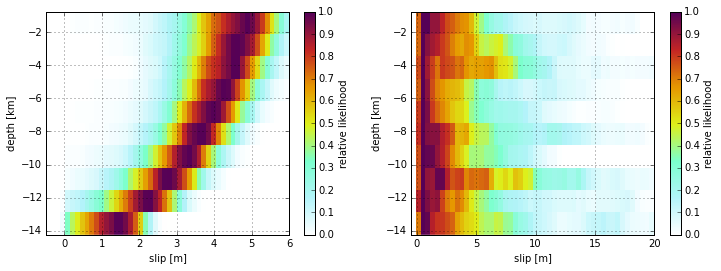

In [20]:
def new_prior_likelihood(model):
  # enforce left-lateral slip
  if np.any(model < 0.0):
    return 0.0

  # if the slip directions and stress drops are agree with
  # the prior then compute the likelihood based on the 
  # potency of the test model
  potency = np.sum(model)*15000.0
  return np.exp(-0.5*((potency-600000.0)/100000.0)**2)

initial_state = 0.1 + np.zeros(M)
step_size = 0.05*np.ones(M)

# find the ensemble of posterior slip models and their 
# corresponding likelihoods
new_post_ensemble,new_post_likelihood = metropolis_hastings(
    initial_state,step_size,new_prior_likelihood,
    observation_likelihood,iterations=1000000)

# Plot the new posterior beside the previous posterior

# Previous posterior
fig,axs = plt.subplots(1,2,figsize=(12,4))
ax1 = axs[0]
ax2 = axs[1]

Nbins = 50
bin_edges = np.linspace(-0.5,6,Nbins+1)
bins = np.array(zip(bin_edges[:-1],bin_edges[1:]))

bin_counts = np.zeros((M,Nbins))
for idx,b in enumerate(bins):
  bin_counts[:,idx] = np.sum((post_ensemble > b[0]) & (post_ensemble < b[1]),axis=0)   

max_counts = np.max(bin_counts,axis=1)
bin_counts /= max_counts[:,None]

im = ax1.imshow(bin_counts,cmap=myplot.cm.slip2,
                extent=[-0.5,6,segment_centers[-1]/1000.0,segment_centers[0]/1000.0],
                aspect='auto',interpolation='none')
cbar = plt.colorbar(im,ax=ax1)
ax1.set_xlabel('slip [m]')
ax1.set_ylabel('depth [km]')
ax1.grid()
cbar.set_label('relative likelihood')

# new posterior
Nbins = 50
bin_edges = np.linspace(-0.5,20,Nbins+1)
bins = np.array(zip(bin_edges[:-1],bin_edges[1:]))

bin_counts = np.zeros((M,Nbins))
for idx,b in enumerate(bins):
  bin_counts[:,idx] = np.sum((new_post_ensemble > b[0]) & (new_post_ensemble < b[1]),axis=0)   

max_counts = np.max(bin_counts,axis=1)
bin_counts /= max_counts[:,None]

im = ax2.imshow(bin_counts,cmap=myplot.cm.slip2,
                extent=[-0.5,20,segment_centers[-1]/1000.0,segment_centers[0]/1000.0],
                aspect='auto',interpolation='none')
cbar = plt.colorbar(im,ax=ax2)
ax2.set_xlabel('slip [m]')
ax2.set_ylabel('depth [km]')
ax2.grid()
cbar.set_label('relative likelihood')
